##### 1) Write a Python program to compute the best-fit line for a set of data points using linear regression. The code should be written in pure Python and you do not need additional libraries (except math). Make your program modular so you end up with a single function called LM(x,y) that takes two lists of numbers as parameters. Here list x will be the list of independent variables and list y will be the list of dependent variables. Your function should output the best fit line “y = b0 + b1x” and the coefficient of determination (r2). Lastly, the function should also plot the data as a scatter plot along with the best fit line.

In [84]:
import math
import pandas as pd # importing these for plotting scatter plot
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

x = [3,7,4,1,5]
y = [7,10,6,4,8]

In [34]:
def LM(x,y):
    # y = b0 + b1 x

    # for b1
    x_ = sum(x)/len(x)
    y_ = sum(y)/len(y)
    x_diff = [i - x_ for i in x]
    y_diff = [i - y_ for i in y]

    numerator = 0
    for i,j in zip(x_diff,y_diff):
        numerator+=i*j

    denomenator = sum([(i-x_)**2 for i in x])
    b1 = numerator/denomenator

    # for b0
    b0 = y_ - b1*x_
    
    print("The equation of best-fit line is: y =",b0,"+",b1,"x")

    y_pred = [b0+b1*i for i in x] # predicting y-values
    # calculating r-squared value
    SST = sum([(i-y_)**2 for i in y]) # SST is the SSE when model is average model
    
    SSE = 0
    for i,j in zip(y,y_pred):
        SSE += (i-j)**2
    SSR = SST-SSE
    r_squared = SSR/SST
    print("r-squared value is",r_squared)
    
    # plotting scatter plot with best-fit line
    df = pd.DataFrame({'x':x,'y':y,'y_pred':y_pred})
    print(ggplot(df,aes(x="x",y="y"))+geom_point()+geom_line(aes(y="y_pred")))


The equation of best-fit line is: y = 3.2 + 0.95 x
r-squared value is 0.9025000000000001


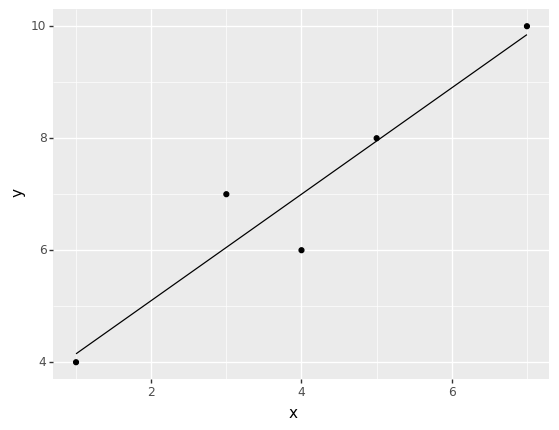

<ggplot: (129238889192)>


In [35]:
LM(x,y)

##### 2) Predict the median value of homes in Boston using a linear regression model. You will use the boston.csv data (both provided here and on Blackboard) and find one independent variable you think is the best predictor for the medv (median value) column. You will test your model using a 70/30 split and show the final R-squared value.

In [109]:
import pandas as pd
from plotnine import *

boston = pd.read_csv('boston.csv')
boston.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


We can ignore ID as it is a unique identifier. We are trying to predict medv, the median value of a property in $1000. The number of rooms, distance from 5 big centers of Boston, and age seem like they should be the best predictors, given their description. Let's check the scatter plot matrix to confirm the relation.

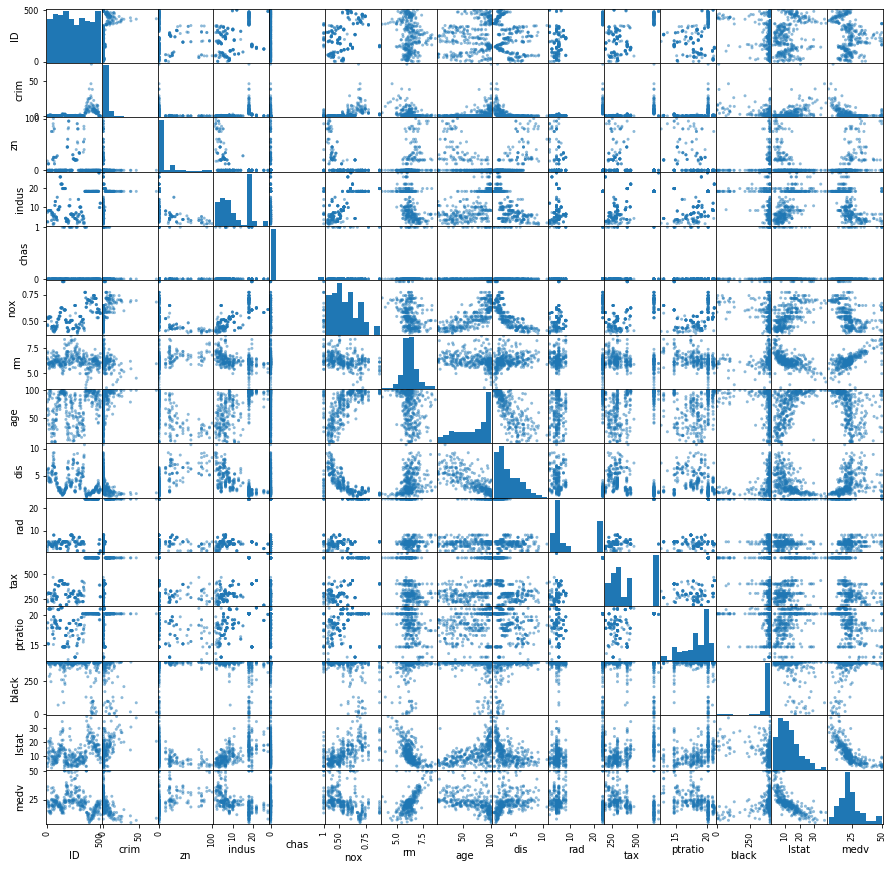

In [38]:
from pandas.plotting import scatter_matrix
scatter_matrix(boston, figsize=(15, 15));

lstat (lower status of the populatio) and rm (average number of rooms) seem like they are most correlated with medv. They can be used for multiple linear regression. For now, we go with lstat.

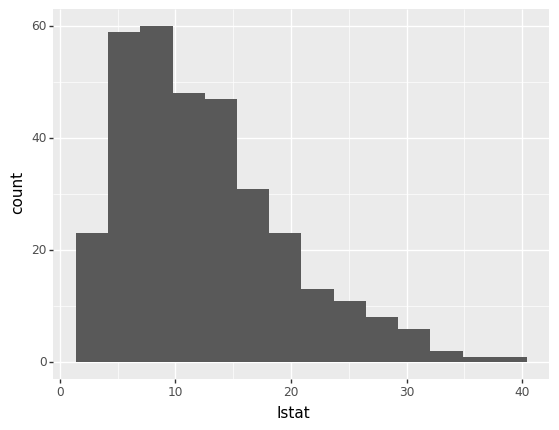

<ggplot: (-9223371907608469244)>

In [110]:
ggplot(boston,aes(x="lstat"))+geom_histogram()

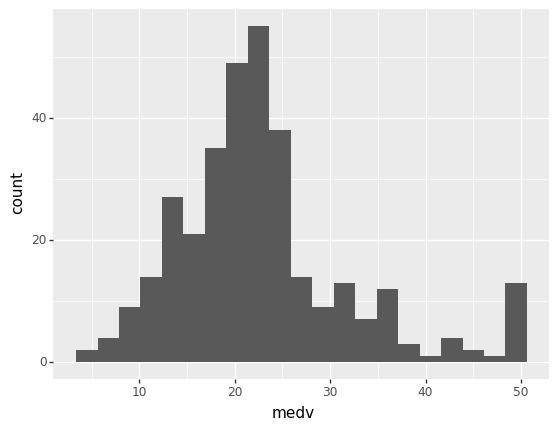

<ggplot: (129246306596)>

In [111]:
ggplot(boston,aes(x="medv"))+geom_histogram()

Here we are looking at the distribution of our selected independent and dependent variables. They should both be normally distributed which is an assumption for fitting a linear regression model on the data. Except for some outliers, medv seems normally distributed, and lstat seems right skewed but unimodal.

Let's check if data contains outliers for lstat. We can transform the value of lstat into z scores.

In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(boston[['lstat']])
boston['lstat_z'] = scaler.transform(boston[['lstat']])

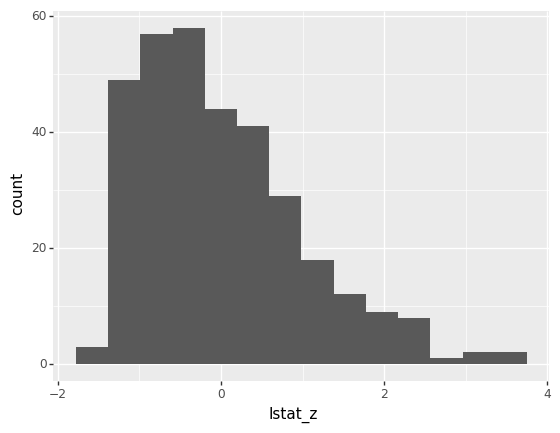

<ggplot: (-9223371907608408211)>

In [113]:
ggplot(boston,aes(x="lstat_z"))+geom_histogram()

We should remove all data points where lstat_z > 3 or lstat_z < -3. That is, remove all data points where lstat is 3 standard deviations away from the lstat mean.

In [114]:
print(boston.shape)
boston = boston.loc[boston['lstat_z'] < 3]
print(boston.shape)

(333, 16)
(329, 16)


We have removed 4 data points that had outlying lstat values. We can now fit our Linear Regression model

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

lm = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(boston[['lstat_z']], boston['medv'], test_size=0.3)

print(X_train.shape) # training on 230 rows
print(X_test.shape) # testing on 99 rows

lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
r2_score(y_test,predictions) # r-squared value when fitting linear regression with lstat_z to predict medv


(230, 1)
(99, 1)


0.5643550561789281

Model says that 56.4% of variation in medv is explained by lstat_z. Because we have a small dataset, we can fit the model multiple times, since selection of train and test data is random, and report the average r-squared value

In [118]:
r_squared_avg = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(boston[['lstat_z']], boston['medv'], test_size=0.3)
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    r_squared_avg.append(r2_score(y_test,predictions))

sum(r_squared_avg)/len(r_squared_avg)

0.5522694893101757

We just re ran the model 100 times, fitting a linear regression model on the data with randomized train and test splits. And the average r-squared value comes out ot be 55.2%

### BONUS

We will first normalize rm attribute and remove outliers.

In [119]:
scaler = StandardScaler()
scaler.fit(boston[['rm']])
boston['rm_z'] = scaler.transform(boston[['rm']])

In [121]:
boston = boston.loc[(boston['rm_z'] > -3) | (boston['rm_z'] < 3)] # removing all rm_z values outside of 3 sd away from rm

We can now fit the model.

In [122]:

lm = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(boston[['lstat_z','rm_z']], boston['medv'], test_size=0.3)

print(X_train.shape) # training on 230 rows
print(X_test.shape) # testing on 99 rows

lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
r2_score(y_test,predictions) # r-squared value when fitting linear regression with lstat_z to predict medv


(230, 2)
(99, 2)


0.6620005034937045

Model says that 66.2% of variation in medv is explained by lstat_z and rm_z. Let's fit the model multiple times, since selection of train and test data is random, and report the average r-squared value

In [123]:
r_squared_avg = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(boston[['lstat_z','rm_z']], boston['medv'], test_size=0.3)
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    r_squared_avg.append(r2_score(y_test,predictions))

sum(r_squared_avg)/len(r_squared_avg)

0.6369837736324975

We just re ran the model 100 times, fitting a linear regression model on the data with randomized train and test splits. And the average r-squared value comes out ot be 63.6%